# YOLO 데이터 형태

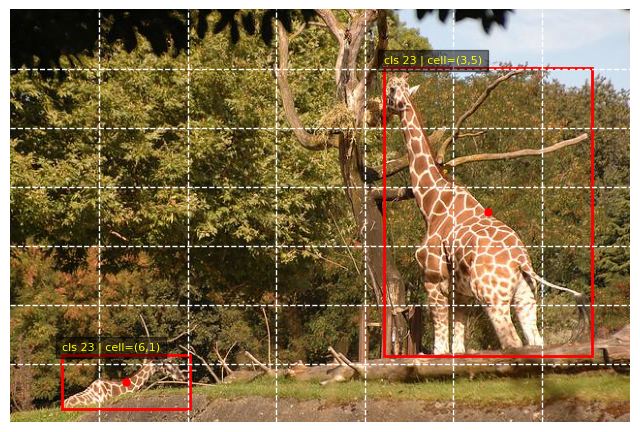

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

def visualize_yolo_label(img_path, labels, S=7, C=80):
    """
    img_path: 이미지 경로
    labels: YOLO txt 포맷 라벨 (리스트 [[cls, x, y, w, h], ...])
    S: grid 크기 (보통 7)
    C: 클래스 수
    """
    # 이미지 불러오기
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(img)

    # 7x7 grid 그리기
    for i in range(1, S):
        ax.axhline(y=H*i/S, color="white", linestyle="--", linewidth=1)
        ax.axvline(x=W*i/S, color="white", linestyle="--", linewidth=1)

    # 각 객체 라벨 표시
    for cls, x, y, w, h in labels:
        # 이미지 기준 좌표로 변환
        x_c, y_c = x*W, y*H
        w_img, h_img = w*W, h*H
        xmin, ymin = x_c - w_img/2, y_c - h_img/2

        # 바운딩 박스
        rect = patches.Rectangle((xmin, ymin), w_img, h_img,
                                 linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)

        # 중심점
        ax.plot(x_c, y_c, "ro", markersize=5)

        # 담당 grid cell 표시
        i, j = int(x*S), int(y*S)   # grid index
        ax.text(xmin, ymin-5, f"cls {int(cls)} | cell=({j},{i})",
                color="yellow", fontsize=8,
                bbox=dict(facecolor="black", alpha=0.5))

    plt.axis("off")
    plt.show()

# 예: COCO YOLO txt 라벨 불러오기
label_path = "/home/jinjinjara1022/AutonomousDriving/paper/YOLO_v1/coco128/labels/train2017/000000000025.txt"
with open(label_path) as f:
    labels = [list(map(float, line.strip().split())) for line in f.readlines()]

img_path = "/home/jinjinjara1022/AutonomousDriving/paper/YOLO_v1/coco128/images/train2017/000000000025.jpg"

visualize_yolo_label(img_path, labels, S=7, C=80)

In [2]:
import torch

def encode_yolo_v1(labels, S=7, B=2, C=80):
    """
    labels: list of [cls, x, y, w, h] (YOLO txt format, normalized)
    return: (S, S, C + B*5) tensor
    """
    label_matrix = torch.zeros((S, S, C + B*5))

    for cls, x, y, w, h in labels:
        i = int(x * S)  # grid x index
        j = int(y * S)  # grid y index

        # 클래스 one-hot
        label_matrix[j, i, int(cls)] = 1

        # 첫 번째 박스에 정보 기록
        label_matrix[j, i, C:C+5] = torch.tensor([x, y, w, h, 1])

        # 두 번째 박스(C+5:C+10)는 그대로 0 (YOLO v1은 한 객체만 기록)
    return label_matrix

# 라벨 파일 읽기
label_path = "/home/jinjinjara1022/AutonomousDriving/paper/YOLO_v1/coco128/labels/train2017/000000000025.txt"
with open(label_path) as f:
    labels = [list(map(float, line.strip().split())) for line in f.readlines()]

# 라벨 텐서 변환
label_tensor = encode_yolo_v1(labels, S=7, B=2, C=80)

print("라벨 텐서 shape:", label_tensor.shape)  # torch.Size([7,7,90])

# 객체가 들어있는 셀만 출력
nonzero_cells = (label_tensor.sum(dim=-1) > 0).nonzero(as_tuple=False)
for (j, i) in nonzero_cells:
    print(f"Cell ({j},{i}):")
    print(label_tensor[j, i, :])

라벨 텐서 shape: torch.Size([7, 7, 90])
Cell (3,5):
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7703,
        0.4897, 0.3359, 0.6976, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])
Cell (6,1):
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0

## DataLoader

In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

# KITTI Object Detection 클래스(학습에 쓰는 것들)
KITTI_CLASSES = [
    "Car", "Van", "Truck",
    "Pedestrian", "Person_sitting", "Cyclist",
    "Tram", "Misc"
]
EXCLUDE_CLASSES = {"DontCare"}  # 필요시 제외

class KITTIDataset(Dataset):
    def __init__(self, root, split_file, S=7, B=2, classes=KITTI_CLASSES, transform=None):
        """
        root: .../kitti_object/training
        split_file: .../kitti_object/ImageSets/train.txt
        """
        self.root = os.path.expanduser(root)
        self.S, self.B = S, B
        self.classes = list(classes)
        self.C = len(self.classes)
        self.class_map = {name: i for i, name in enumerate(self.classes)}

        self.transform = transform or T.Compose([
            T.Resize((448, 448)),
            T.ToTensor()
        ])

        with open(os.path.expanduser(split_file)) as f:
            self.ids = [x.strip() for x in f if x.strip()]

        self.img_dir = os.path.join(self.root, "image_2")
        self.label_dir = os.path.join(self.root, "label_2")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]

        # 이미지 로드 (원본 크기 기반 정규화가 맞음)
        img_path = os.path.join(self.img_dir, f"{img_id}.png")
        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size  # KITTI는 보통 1242x375지만 파일별로 읽는 게 안전

        image = self.transform(image)  # 정규화 값은 0~1이므로 리사이즈와 무관

        # (S, S, C + 5B) 라벨 텐서
        label_matrix = torch.zeros((self.S, self.S, self.C + self.B * 5), dtype=torch.float32)

        # 라벨 로드
        label_path = os.path.join(self.label_dir, f"{img_id}.txt")
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    cls_name = parts[0]
                    if cls_name in EXCLUDE_CLASSES:
                        continue
                    if cls_name not in self.class_map:
                        # (원하면 여기서 새 클래스를 자동 추가하도록 확장 가능)
                        continue

                    # x1, y1, x2, y2
                    x1, y1, x2, y2 = map(float, parts[4:8])

                    # bbox를 이미지 경계로 클램프(간혹 라벨이 약간 벗어나는 경우 방지)
                    x1 = max(0.0, min(x1, orig_w - 1))
                    x2 = max(0.0, min(x2, orig_w - 1))
                    y1 = max(0.0, min(y1, orig_h - 1))
                    y2 = max(0.0, min(y2, orig_h - 1))
                    if x2 <= x1 or y2 <= y1:
                        continue  # 잘못된 박스 스킵

                    # YOLO 좌표 (이미지 전체 기준 정규화)
                    cx = ((x1 + x2) / 2.0) / orig_w
                    cy = ((y1 + y2) / 2.0) / orig_h
                    w  = (x2 - x1) / orig_w
                    h  = (y2 - y1) / orig_h

                    # 그리드 인덱스 (경계값 안전 처리)
                    i = int(min(self.S - 1, max(0, cx * self.S)))
                    j = int(min(self.S - 1, max(0, cy * self.S)))

                    # 이미 객체가 있는 셀일 때 처리:
                    # YOLOv1 라벨은 셀당 1개 클래스만 원칙 → 이미 채워져 있으면 스킵
                    # (동일 셀에 여러 객체가 들어오면 첫 것만 사용)
                    if label_matrix[j, i, :self.C].sum() > 0:
                        continue

                    cls_id = self.class_map[cls_name]
                    # one-hot 클래스
                    label_matrix[j, i, cls_id] = 1.0
                    # 첫 번째 박스에 값 채움 (x,y,w,h,conf=1)
                    label_matrix[j, i, self.C:self.C+5] = torch.tensor([cx, cy, w, h, 1.0])

        return image, label_matrix

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

def visualize_from_tensor(img, label, B=2, class_names=None):
    """
    img: (3, 448, 448) tensor
    label: (S, S, C + 5B) tensor
    """
    img_np = img.permute(1, 2, 0).numpy()
    H, W = img_np.shape[:2]
    S = label.shape[0]
    C = label.shape[-1] - B * 5

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img_np)

    # grid
    for k in range(1, S):
        ax.axhline(y=H * k / S, color="white", linestyle="--", linewidth=1)
        ax.axvline(x=W * k / S, color="white", linestyle="--", linewidth=1)

    for j in range(S):
        for i in range(S):
            cell = label[j, i]
            if cell[:C].sum() == 0:
                continue

            class_id = int(torch.argmax(cell[:C]).item())
            x, y, w, h, conf = cell[C:C+5].tolist()
            if conf <= 0:
                continue

            x_c, y_c = x * W, y * H
            w_img, h_img = w * W, h * H
            xmin, ymin = x_c - w_img / 2, y_c - h_img / 2

            rect = patches.Rectangle((xmin, ymin), w_img, h_img,
                                     linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.plot(x_c, y_c, "ro", markersize=4)

            if class_names and 0 <= class_id < len(class_names):
                label_txt = class_names[class_id]
            else:
                label_txt = f"cls {class_id}"
            ax.text(xmin, ymin - 5, label_txt, color="yellow",
                    fontsize=8, bbox=dict(facecolor="black", alpha=0.5))

    plt.axis("off")
    plt.show()

torch.Size([3, 448, 448])
torch.Size([7, 7, 18])


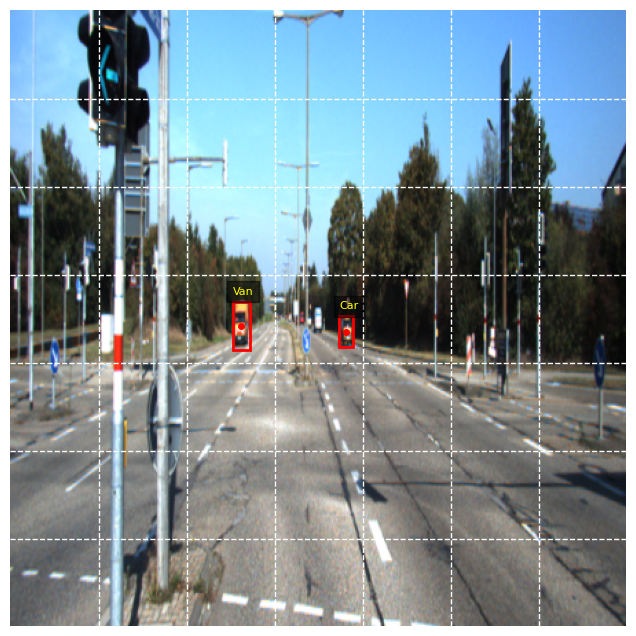

In [5]:
dataset = KITTIDataset(
    root="/home/jinjinjara1022/AutonomousDriving/datasets/kitti_object/training",
    split_file="/home/jinjinjara1022/AutonomousDriving/datasets/kitti_object/ImageSets/train.txt",
    S=7, B=2, classes=KITTI_CLASSES  # C는 자동: len(classes)=8
)

img, label = dataset[9]
print(img.shape)    # torch.Size([3, 448, 448])
print(label.shape)  # torch.Size([7, 7, 8 + 10]) = [7, 7, 18]

visualize_from_tensor(img, label, B=2, class_names=KITTI_CLASSES)

# Model

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class YOLOv1(nn.Module):
    def __init__(self, S=7, B=2, C=8):
        super(YOLOv1, self).__init__()
        self.S, self.B, self.C = S, B, C

        # VGG16 Backbone
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

        # features는 conv+relu+pool 레이어
        features = list(vgg.features.children())

        # 원래 VGG는 5개의 MaxPool → 448 입력시 14x14 출력
        # YOLOv1은 최종 stride가 더 커야 7x7이 되므로 마지막 pool 하나 더 추가하거나 stride=2 conv 사용
        # 간단히: features 뒤에 MaxPool2d(kernel=2, stride=2) 추가
        features.append(nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv = nn.Sequential(*features)

        # fc는 항상 7x7x512(=25088) 기준이므로 448입력시에도 맞음
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, S * S * (C + B * 5))
        )

    def forward(self, x):
        x = self.conv(x)            # [batch, 512, 7, 7]
        x = self.fc(x)
        return x.view(-1, self.S, self.S, self.C + self.B * 5)


In [7]:
dummy_input = torch.randn(1, 3, 448, 448)  # (batch_size, channels, height, width)
model = YOLOv1(S=7, B=2, C=8)
output = model(dummy_input)
print("모델 출력 shape:", output.shape)

모델 출력 shape: torch.Size([1, 7, 7, 18])


## Loss

In [8]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=8, lambda_coord=5, lambda_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.S, self.B, self.C = S, B, C
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse = nn.MSELoss(reduction="sum")

    def forward(self, pred, target):
        # pred, target: (N, S, S, C + B*5)

        # 1. 클래스 확률 로스
        class_loss = self.mse(pred[..., :self.C], target[..., :self.C])

        # 2. BBox 좌표 로스 (첫 번째 박스 기준)
        pred_box = pred[..., self.C:self.C+5]
        target_box = target[..., self.C:self.C+5]

        coord_loss = self.mse(pred_box[..., :2], target_box[..., :2])  # (x,y)
        coord_loss += self.mse(
            torch.sqrt(torch.clamp(pred_box[..., 2:4], min=1e-6)),
            torch.sqrt(torch.clamp(target_box[..., 2:4], min=1e-6))
        )  # (w,h)

        # 3. confidence 로스
        obj_loss = self.mse(pred_box[..., 4], target_box[..., 4])

        # no-object 로스 (obj==0 인 셀만 고려)
        mask_noobj = (target_box[..., 4] == 0).float()
        noobj_loss = self.mse(pred_box[..., 4] * mask_noobj, target_box[..., 4] * mask_noobj)

        # 총합
        total_loss = (self.lambda_coord * coord_loss) + obj_loss + (self.lambda_noobj * noobj_loss) + class_loss
        return total_loss


In [9]:
loss_fn = YoloLoss(S=7, B=2, C=8)

dummy_pred, dummy_target = torch.randn(1, 7, 7, 90), torch.randn(1, 7, 7, 90)
loss = loss_fn(dummy_pred, dummy_target)
print("손실 값:", loss.item())

손실 값: 1973.5196533203125


## Train

In [11]:
from torch.utils.data import DataLoader

# DataLoader 만들기
train_loader = DataLoader(
    dataset,
    batch_size=256,     # 배치 크기
    shuffle=True,     # 학습 시 섞기
    drop_last=True    # 마지막 배치 버림 (shape 일정하게)
)

In [12]:
import torch.optim as optim

# 모델, 손실, 옵티마이저 정의
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cuda:4"
model = YOLOv1(S=7, B=2, C=8).to(device)
criterion = YoloLoss(S=7, B=2, C=8)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
epochs = 10 
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"[Epoch {epoch+1}/{epochs}] Loss: {epoch_loss/len(train_loader):.4f}")


[Epoch 1/10] Loss: 6709.4787
[Epoch 2/10] Loss: 4453.0715
[Epoch 3/10] Loss: 4062.5504
[Epoch 4/10] Loss: 3719.0169
[Epoch 5/10] Loss: 3440.8467
[Epoch 6/10] Loss: 3216.2034
[Epoch 7/10] Loss: 2992.1496
[Epoch 8/10] Loss: 2792.2187
[Epoch 9/10] Loss: 2628.9981
[Epoch 10/10] Loss: 2453.8725


## Inference

In [13]:
import torch
import numpy as np

def inference(model, img, S=7, B=2, C=80, conf_threshold=0.3):
    """
    img: torch.Tensor (3, 448, 448)
    return: [(class_id, score, (xmin,ymin,xmax,ymax)), ...]
    """
    model.eval()
    with torch.no_grad():
        preds = model(img.unsqueeze(0))  # (1, S, S, C+5B)
        preds = preds.squeeze(0)         # (S, S, C+5B)

    boxes = []
    for i in range(S):
        for j in range(S):
            cell = preds[j, i]

            # 클래스 예측
            class_scores = cell[:C]
            class_id = torch.argmax(class_scores).item()
            class_prob = torch.softmax(class_scores, dim=0)[class_id].item()

            # 첫 번째 박스만 사용 (YOLOv1에서는 보통 하나 선택)
            x, y, w, h, conf = cell[C:C+5].tolist()
            score = conf * class_prob

            if score > conf_threshold:
                # 이미지 좌표로 변환
                W, H = 448, 448
                x_c, y_c = x * W, y * H
                w_img, h_img = w * W, h * H
                xmin, ymin = x_c - w_img/2, y_c - h_img/2
                xmax, ymax = x_c + w_img/2, y_c + h_img/2

                boxes.append((class_id, score, (xmin, ymin, xmax, ymax)))

    return boxes


In [14]:
def nms(boxes, iou_threshold=0.5):
    """
    boxes: [(class_id, score, (xmin,ymin,xmax,ymax)), ...]
    return: filtered boxes
    """
    if not boxes:
        return []

    # 점수 기준으로 정렬
    boxes = sorted(boxes, key=lambda x: x[1], reverse=True)
    keep = []

    while boxes:
        best = boxes.pop(0)
        keep.append(best)
        boxes = [box for box in boxes if iou(best[2], box[2]) < iou_threshold]

    return keep

def iou(box1, box2):
    xmin1, ymin1, xmax1, ymax1 = box1
    xmin2, ymin2, xmax2, ymax2 = box2

    inter_xmin = max(xmin1, xmin2)
    inter_ymin = max(ymin1, ymin2)
    inter_xmax = min(xmax1, xmax2)
    inter_ymax = min(ymax1, ymax2)

    inter_w = max(0, inter_xmax - inter_xmin)
    inter_h = max(0, inter_ymax - inter_ymin)
    inter_area = inter_w * inter_h

    area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0


In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_inference(img, boxes, class_names=None):
    img = img.permute(1,2,0).numpy()
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(img)

    for cls, score, (xmin, ymin, xmax, ymax) in boxes:
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                 linewidth=2, edgecolor="lime", facecolor="none")
        ax.add_patch(rect)
        label = f"{class_names[cls] if class_names else cls}:{score:.2f}"
        ax.text(xmin, ymin-5, label, color="yellow",
                fontsize=8, bbox=dict(facecolor="black", alpha=0.5))

    plt.axis("off")
    plt.show()


탐지된 객체 수: 2


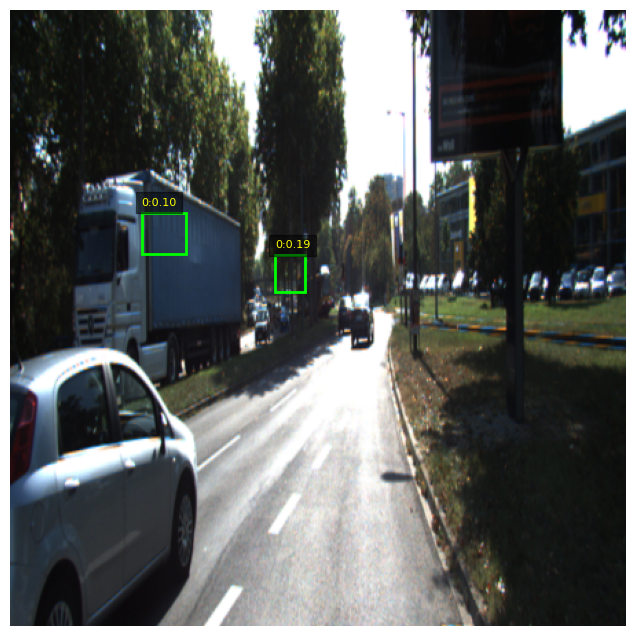

In [16]:
# 데이터셋에서 하나 꺼내오기
img, _ = dataset[12]
model.to("cpu") 
boxes = inference(model, img, S=7, B=2, C=8, conf_threshold=0.1)
final_boxes = nms(boxes, iou_threshold=0.5)

print("탐지된 객체 수:", len(final_boxes))
visualize_inference(img, final_boxes)
